# 说明
用于实现AAnet的训练和测试,使用lightning框架

## 加载数据集并划分训练集和验证集
需要修改的地方：
- file_dir: 数据集的路径
- gesture_classes: 手势的类别数
- sample_num: 每个类别的样本数


In [1]:
import scipy.io as sio
import torch
from sklearn.preprocessing import OneHotEncoder
from torchsummary import summary
import torch.utils.data as data
import lightning as L
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)   # 固定随机种子

file_dir = 'out\\pyfeature\\'
file_dir = 'out\\test\\pyfeature\\'
gesture_classes = 2
sample_num = 100

def load_data(file_path, gesture_index):
    """加载数据"""
    filename = file_path + str(gesture_index) + '.mat'
    data = sio.loadmat(filename)
    range_profile = torch.tensor(data['range_profile'], dtype=torch.float32)
    speed_profile = torch.tensor(data['speed_profile'], dtype=torch.float32)
    angle_profile = torch.tensor(data['angle_profile'], dtype=torch.float32)
    return range_profile, speed_profile, angle_profile

def generate_labels(gesture_class, sample_num):
    """生成标签"""
    labels = torch.zeros((gesture_class * sample_num, 1))
    for i in range(gesture_class):
        labels[i * sample_num:(i + 1) * sample_num] = i
    enc = OneHotEncoder()
    labels = enc.fit_transform(labels).toarray()
    return torch.tensor(labels, dtype=torch.float32)

# 初始化数据集
range_profile = torch.zeros((gesture_classes * sample_num, 30, 64), dtype=torch.float32)
speed_profile = torch.zeros((gesture_classes * sample_num, 30, 64), dtype=torch.float32)
angle_profile = torch.zeros((gesture_classes * sample_num, 30, 64), dtype=torch.float32)

labels = generate_labels(gesture_classes, sample_num)   # 生成标签

# 加载数据
for i in range(gesture_classes):
    range_profile[i * sample_num:(i + 1) * sample_num, :, :], \
    speed_profile[i * sample_num:(i + 1) * sample_num, :, :], \
    angle_profile[i * sample_num:(i + 1) * sample_num, :, :] = load_data(file_dir, i + 1)

# dataset = range_profile
# dataset = speed_profile
dataset = angle_profile


dataset_loader = data.TensorDataset(dataset, labels)


# 将数据划分为训练集和验证集
train_loader, val_loader= data.random_split(dataset_loader, [0.8, 0.2])

Seed set to 42
C:\Users\Du\AppData\Local\Temp\ipykernel_31204\1651246264.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:299.)
  range_profile = torch.tensor(data['range_profile'], dtype=torch.float32)


In [2]:
# 定义模型
# --------------------------------
# 步骤 2: 定义 RadarGestureNet
# --------------------------------
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
def one_hot_labels(caategorical_labels):
    enc = OneHotEncoder(handle_unknown='ignore')
    on_hot_labels = enc.fit_transform(
        caategorical_labels.reshape(-1, 1)).toarray()
    return on_hot_labels
def one_hot_to_label(one_hot):
    return torch.argmax(one_hot, dim=1)

# encoder = nn.Sequential(
#             nn.LayerNorm([30, 64]),
#             nn.Conv1d(30, 8, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(512, gesture_class),
#         )

encoder = nn.Sequential(
            nn.LayerNorm([30, 64]),
            nn.Conv1d(30, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, gesture_classes),
        )
# encoder = nn.Sequential(
#             nn.LayerNorm([30, 64]),
#             nn.Flatten(),
#             nn.Linear(64*30, 20),
#             nn.ReLU(),
#             nn.Linear(20, gesture_class),
#             )

class RadarGestureNet(L.LightningModule):
    def __init__(self, encoder, gesture_class):
        super().__init__()
        self.gesture_class = gesture_class
        self.save_hyperparameters(encoder, gesture_class)
        self.encoder = encoder
    def forward(self, x):
        embedding = self.encoder(x)
        return embedding
    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        criterion = nn.MSELoss()
        loss = criterion(z, y)
        self.log("train_loss", loss)
        train_accuracy = torch.sum(one_hot_to_label(z) == one_hot_to_label(y)).item() / len(y)
        self.log("train_accuracy", train_accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        criterion = nn.MSELoss()
        val_loss = criterion(z, y)
        self.log("val_loss", val_loss)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        criterion = nn.MSELoss()
        
        test_loss = criterion(z, y)
        self.log("test_loss", test_loss)
        
        accuracy = torch.sum(one_hot_to_label(z) == one_hot_to_label(y)).item() / len(y)
        self.log("accuracy", accuracy)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [3]:
# 训练模型
# -------------------
# 步骤 3: 训练
# -------------------
# autoencoder = LitAutoEncoder()

model = RadarGestureNet(encoder=encoder, gesture_class=gesture_classes)
summary(model, input_size=(30, 64),device="cpu")
trainer = L.Trainer(
    max_epochs=150,
    log_every_n_steps=1,
    deterministic=True,
    enable_progress_bar=False,
    enable_model_summary=False,
    )

train_data_loader = data.DataLoader(train_loader, batch_size=512, shuffle=True)
val_data_loader = data.DataLoader(val_loader, batch_size=512, shuffle=False)

trainer.fit(model, train_data_loader, val_data_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1               [-1, 30, 64]           3,840
            Conv1d-2               [-1, 16, 64]           1,456
              ReLU-3               [-1, 16, 64]               0
            Conv1d-4                [-1, 8, 64]             392
              ReLU-5                [-1, 8, 64]               0
            Conv1d-6                [-1, 4, 64]             100
              ReLU-7                [-1, 4, 64]               0
           Flatten-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
Total params: 47,070
Trainable params: 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
k:\aio_radar\.conda\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
k:\aio_radar\.conda\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=150` reached.


In [11]:
# 验证损失
# trainer.test(model, data.DataLoader(train_loader,batch_size=256))
trainer.test(model, data.DataLoader(val_loader,batch_size=256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.949999988079071     │
│         test_loss         │    0.04430491104722023    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04430491104722023, 'accuracy': 0.949999988079071}]

In [14]:
# 加载模型
# model_path = r'I:\aio\aio_radar\aio_network\lightning_logs\version_224\checkpoints\epoch=74-step=300.ckpt'
# model = RadarGestureNet.load_from_checkpoint(model_path).to("cpu")

# 预测
# predictions = model(torch.rand(angle_profile.shape[0],30,64))
predictions = model(angle_profile)

# 准确率
print(torch.sum(one_hot_to_label(predictions) == one_hot_to_label(labels)).item() / len(labels))
print(one_hot_to_label(predictions))



0.99
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


torch.Size([200, 30, 64])


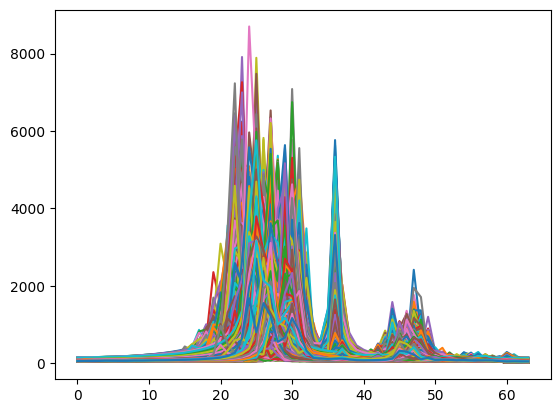

In [15]:
print(range_profile.shape)
# 绘制range_profile
import matplotlib.pyplot as plt
plt.plot(range_profile[0,3,:])
for i in range(range_profile.shape[0]):
    for j in range(range_profile.shape[1]):
        plt.plot(range_profile[i,j,:])
plt.show()
    

torch.Size([200, 30, 64])


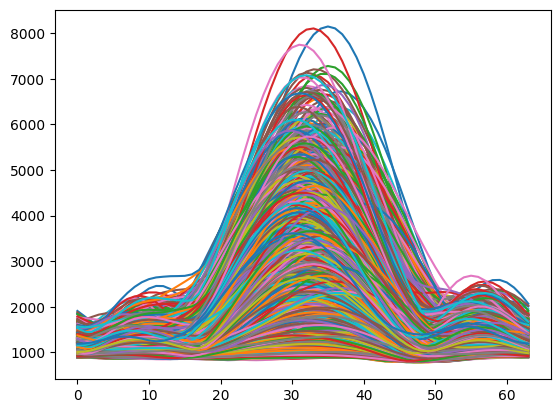

In [16]:
print(angle_profile.shape)
# 绘制angle_profile
import matplotlib.pyplot as plt
plt.plot(angle_profile[0,3,:])
for i in range(angle_profile.shape[0]):
    for j in range(angle_profile.shape[1]):
        plt.plot(angle_profile[i,j,:])
plt.show()